# Ensemble classification model in earthquake building damage level detection

# Importing Libraries

In [1]:
!pip install xgboost
!pip install catboost
!pip install imbalanced-ensemble
!pip install sdv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 46 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 268 kB 32.3 MB/s 
     |████████████████████████████████| 9.4 MB 62.0 MB/s 
     |████████████████████████████████| 295 kB 92.3 MB/s 
     |████████████████████████████████| 965 kB 84.2 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 102 kB 9.9 MB/s 
     |████████████████████████████████| 1.6 MB 53.3 MB/s 
     |████████████████████████████████| 53 kB 2.1 MB/s 
     |████████████████████████████████| 139 kB 88.3 MB/s 
     |████████████████████████████████| 47 kB 5.7 MB/s 
     |████████████████████████████████| 61 kB 6.2 kB/s 
     |████████████████████████████████| 280 kB 87.6 MB/s 
     |████████████████████████████████| 662 kB 104.8 MB/s 
     |████████████████████████████████| 15.3 MB 91.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8
  Attempting uninstall: plotly
    Found existing installation: plotly 5.5.0
    Unins

In [2]:
import numpy as np
import pandas as pd
import cv2
from sdv import SDV

from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from google.colab import drive

import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb

# Data Loading

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
X = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/data/train_values.csv", index_col='building_id')

In [5]:
X.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
28830,8,900,2812,2,10,8,7,o,r,n,...,0,0,0,0,0,0,0,0,0,0
94947,21,363,8973,2,10,5,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
590882,22,418,10694,2,10,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
201944,11,131,1488,3,30,8,9,t,r,n,...,0,0,0,0,0,0,0,0,0,0


In [6]:
Y= pd.read_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/data/train_labels.csv", index_col='building_id')

In [7]:
Y.head()

,damage_grade
building_id,
802906,3
28830,2
94947,3
590882,2
201944,3


In [8]:
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/data/test_values.csv", index_col='building_id')

In [9]:
X.describe()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
count,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,...,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000
mean,13.900353,701.074685,6257.876148,2.129723,26.535029,8.018051,5.434365,0.088645,0.761935,0.034332,...,0.064378,0.033626,0.008101,0.000940,0.000361,0.001071,0.000188,0.000146,0.000088,0.005119
std,8.033617,412.710734,3646.369645,0.727665,73.565937,4.392231,1.918418,0.284231,0.425900,0.182081,...,0.245426,0.180265,0.089638,0.030647,0.018989,0.032703,0.013711,0.012075,0.009394,0.071364
min,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,350.000000,3073.000000,2.000000,10.000000,5.000000,4.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.000000,702.000000,6270.000000,2.000000,15.000000,7.000000,5.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,21.000000,1050.000000,9412.000000,2.000000,30.000000,9.000000,6.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30.000000,1427.000000,12567.000000,9.000000,995.000000,100.000000,32.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Generated Data

## Test Generated Data

In [ ]:
from sdv.demo import load_tabular_demo
data = load_tabular_demo('student_placements')
data

,student_id,gender,second_perc,high_perc,high_spec,degree_perc,degree_type,work_experience,experience_years,employability_perc,mba_spec,mba_perc,salary,placed,start_date,end_date,duration
0,17264,M,67.00,91.00,Commerce,58.00,Sci&Tech,False,0,55.0,Mkt&HR,58.80,27000.0,True,2020-07-23,2020-10-12,3.0
1,17265,M,79.33,78.33,Science,77.48,Sci&Tech,True,1,86.5,Mkt&Fin,66.28,20000.0,True,2020-01-11,2020-04-09,3.0
2,17266,M,65.00,68.00,Arts,64.00,Comm&Mgmt,False,0,75.0,Mkt&Fin,57.80,25000.0,True,2020-01-26,2020-07-13,6.0
3,17267,M,56.00,52.00,Science,52.00,Sci&Tech,False,0,66.0,Mkt&HR,59.43,NaN,False,NaT,NaT,NaN
4,17268,M,85.80,73.60,Commerce,73.30,Comm&Mgmt,False,0,96.8,Mkt&Fin,55.50,42500.0,True,2020-07-04,2020-09-27,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,17474,M,80.60,82.00,Commerce,77.60,Comm&Mgmt,False,0,91.0,Mkt&Fin,74.49,40000.0,True,2020-07-27,2020-10-20,3.0
211,17475,M,58.00,60.00,Science,72.00,Sci&Tech,False,0,74.0,Mkt&Fin,53.62,27500.0,True,2020-01-23,2020-08-04,6.0
212,17476,M,67.00,67.00,Commerce,73.00,Comm&Mgmt,True,1,59.0,Mkt&Fin,69.72,29500.0,True,2020-01-25,2020-08-05,6.0
213,17477,F,74.00,66.00,Commerce,58.00,Comm&Mgmt,False,0,70.0,Mkt&HR,60.23,20400.0,True,2020-01-19,2020-04-20,3.0


In [ ]:
from sdv.tabular import CTGAN
model = CTGAN(verbose=True)
model.fit(data)

/usr/local/lib/python3.8/dist-packages/ctgan/data_transformer.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column_name] = data[column_name].to_numpy().flatten()
/usr/local/lib/python3.8/dist-packages/ctgan/data_transformer.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column_name] = data[column_name].to_numpy().flatten()
/usr/local/lib/python3.8/dist-packages/ctgan/data_transformer.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


Epoch 1, Loss G:  0.8540,Loss D: -0.0574
Epoch 2, Loss G:  0.8452,Loss D: -0.0390
Epoch 3, Loss G:  0.8540,Loss D: -0.0631
Epoch 4, Loss G:  0.8282,Loss D: -0.0539
Epoch 5, Loss G:  0.7879,Loss D: -0.0803
Epoch 6, Loss G:  0.7999,Loss D: -0.0753
Epoch 7, Loss G:  0.7719,Loss D: -0.1008
Epoch 8, Loss G:  0.7635,Loss D: -0.0885
Epoch 9, Loss G:  0.7176,Loss D: -0.1028
Epoch 10, Loss G:  0.6657,Loss D: -0.1110
Epoch 11, Loss G:  0.6264,Loss D: -0.1350
Epoch 12, Loss G:  0.6288,Loss D: -0.0795
Epoch 13, Loss G:  0.5764,Loss D: -0.1129
Epoch 14, Loss G:  0.5931,Loss D: -0.0868
Epoch 15, Loss G:  0.4476,Loss D: -0.1303
Epoch 16, Loss G:  0.4160,Loss D: -0.1667
Epoch 17, Loss G:  0.4001,Loss D: -0.0050
Epoch 18, Loss G:  0.3552,Loss D: -0.1799
Epoch 19, Loss G:  0.4109,Loss D: -0.1200
Epoch 20, Loss G:  0.2910,Loss D: -0.1577
Epoch 21, Loss G:  0.3278,Loss D: -0.0186
Epoch 22, Loss G:  0.1941,Loss D: -0.1616
Epoch 23, Loss G:  0.2449,Loss D: -0.1680
Epoch 24, Loss G:  0.1322,Loss D: -0.0703
E

In [ ]:
new_data = model.sample(num_rows=20000)
new_data

,student_id,gender,second_perc,high_perc,high_spec,degree_perc,degree_type,work_experience,experience_years,employability_perc,mba_spec,mba_perc,salary,placed,start_date,end_date,duration
0,17323,M,60.89,63.04,Science,70.16,Sci&Tech,False,0,51.98,Mkt&Fin,57.00,26889.0,True,2020-05-19,2020-11-06,12.0
1,17437,F,76.85,48.82,Commerce,61.91,Comm&Mgmt,False,0,56.47,Mkt&Fin,77.89,34369.0,False,NaT,2020-05-30,NaN
2,17471,M,89.40,76.92,Science,79.38,Comm&Mgmt,True,1,85.08,Mkt&Fin,60.05,55952.0,True,NaT,NaT,NaN
3,17383,F,65.26,92.40,Commerce,87.53,Others,False,1,95.85,Mkt&HR,66.35,NaN,False,2020-03-21,2020-06-03,NaN
4,17299,M,52.36,54.43,Arts,57.65,Comm&Mgmt,True,0,57.45,Mkt&HR,56.48,NaN,True,NaT,NaT,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,17425,M,75.38,52.02,Science,70.86,Others,True,0,68.05,Mkt&HR,76.38,NaN,True,NaT,2020-07-18,NaN
19996,17438,F,87.66,62.43,Commerce,76.82,Sci&Tech,False,1,67.20,Mkt&Fin,74.07,NaN,True,2020-03-21,NaT,NaN
19997,17286,M,86.43,65.80,Commerce,62.35,Sci&Tech,True,0,50.00,Mkt&HR,75.70,27535.0,True,NaT,2020-06-14,3.0
19998,17476,F,89.40,37.00,Commerce,50.76,Sci&Tech,True,0,60.62,Mkt&HR,56.99,26963.0,True,NaT,NaT,3.0


In [ ]:
!pip install table_evaluator
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


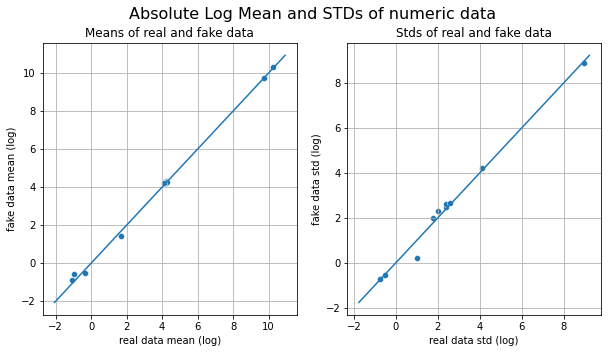

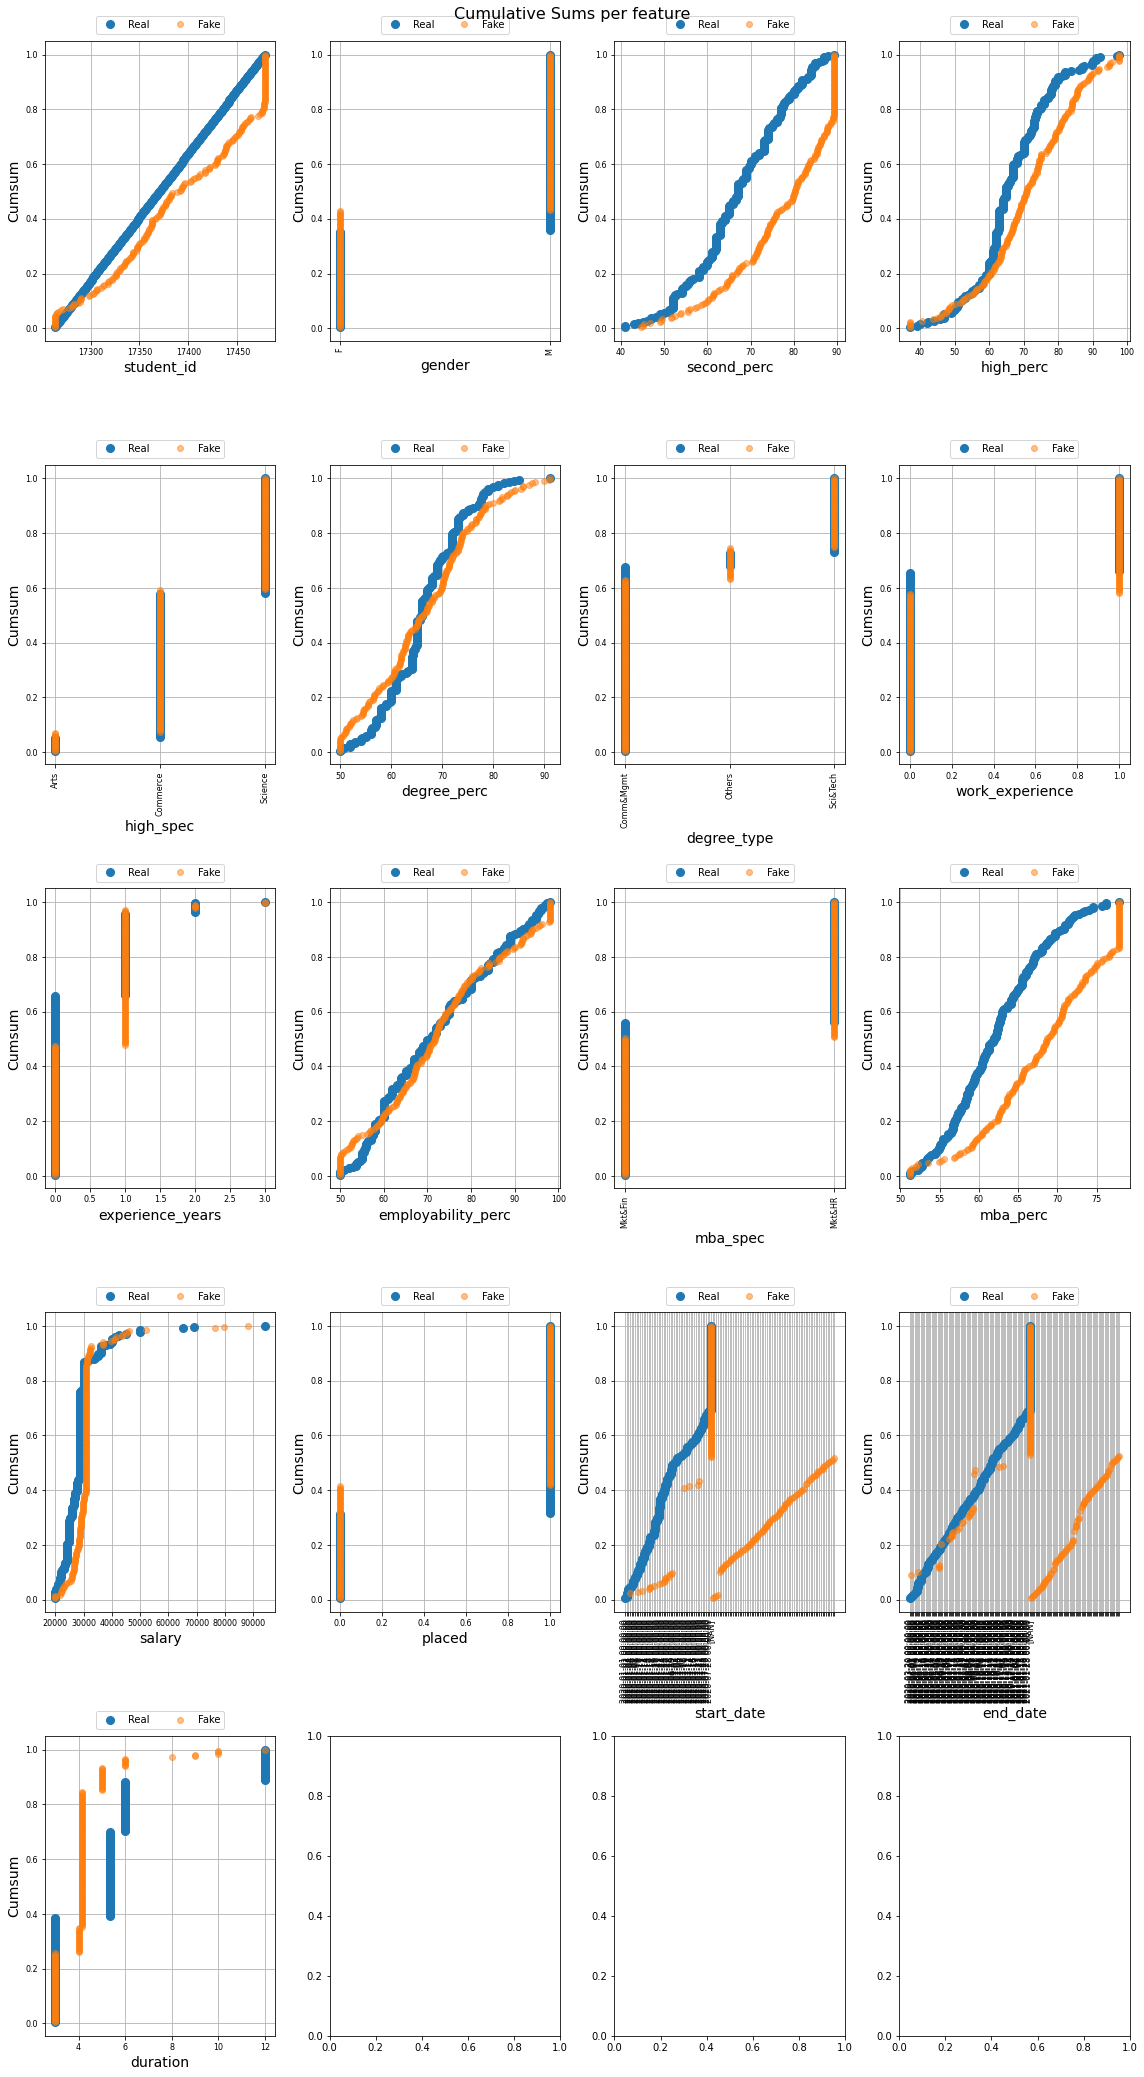

ValueError: ignored

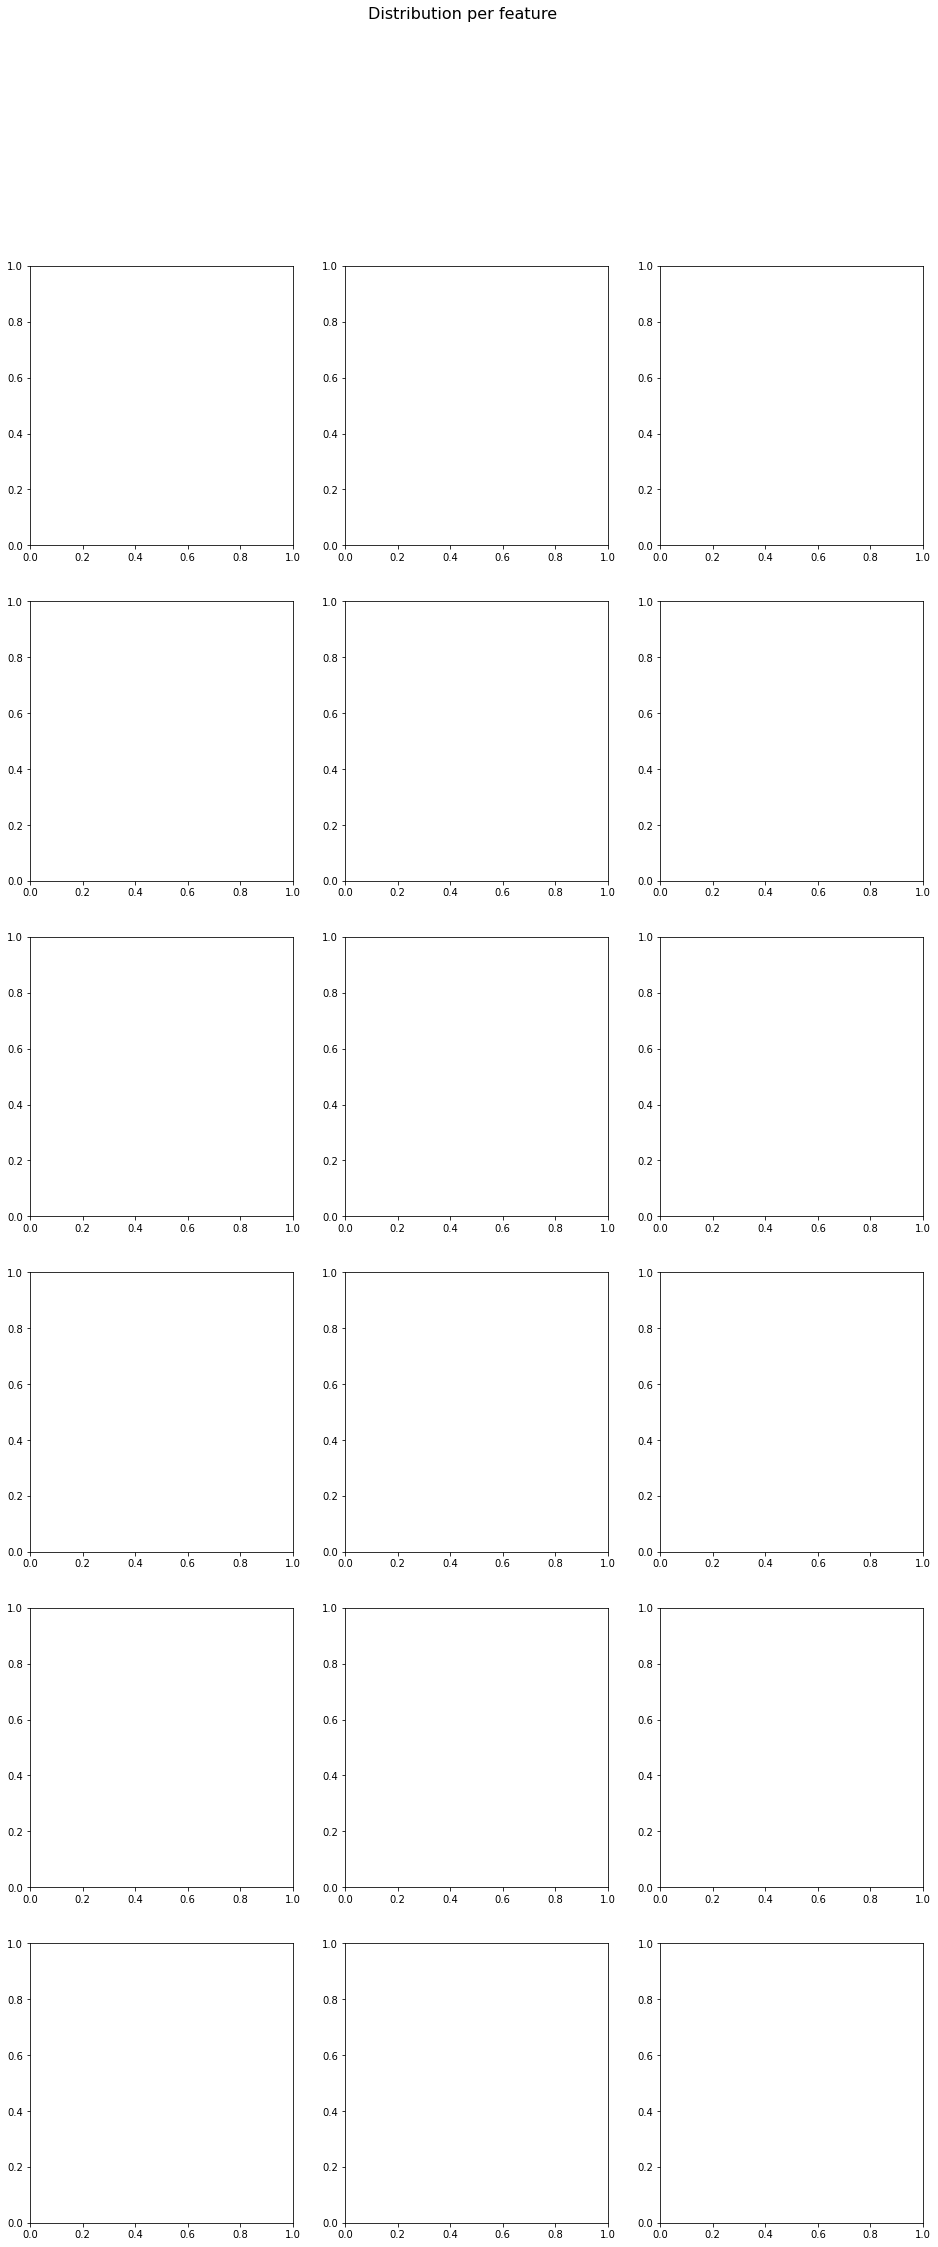

In [ ]:
import matplotlib.pyplot as plt
from table_evaluator import TableEvaluator

table_evaluator = TableEvaluator(data,new_data)
table_evaluator.visual_evaluation()

## Using Generated Data

In [10]:
Y.value_counts()[Y.value_counts().index == (2,)].values - Y.value_counts()

damage_grade
2                    0
3                61041
1               123135
dtype: int64

In [11]:
data_real = X

In [12]:
data_real.shape

(260601, 38)

In [13]:
data_real["damage"] = Y

In [14]:
data_real.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,3
28830,8,900,2812,2,10,8,7,o,r,n,...,0,0,0,0,0,0,0,0,0,2
94947,21,363,8973,2,10,5,5,t,r,n,...,0,0,0,0,0,0,0,0,0,3
590882,22,418,10694,2,10,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,2
201944,11,131,1488,3,30,8,9,t,r,n,...,0,0,0,0,0,0,0,0,0,3


In [ ]:
from sdv.tabular import CTGAN

model = CTGAN(
    verbose=True,
    cuda=True
    )

model.fit(data_real.query("damage == 1"))

Epoch 1, Loss G:  0.6121,Loss D: -0.2431
Epoch 2, Loss G: -0.6239,Loss D: -0.0433
Epoch 3, Loss G: -0.4828,Loss D:  0.0872
Epoch 4, Loss G: -1.2136,Loss D: -0.1066
Epoch 5, Loss G: -1.3312,Loss D: -0.1816
Epoch 6, Loss G: -1.8125,Loss D: -0.0436
Epoch 7, Loss G: -1.9043,Loss D:  0.2245
Epoch 8, Loss G: -1.8884,Loss D: -0.0447
Epoch 9, Loss G: -1.4070,Loss D:  0.0162
Epoch 10, Loss G: -1.9134,Loss D: -0.4256
Epoch 11, Loss G: -1.5646,Loss D:  0.0637
Epoch 12, Loss G: -1.6465,Loss D: -0.0763
Epoch 13, Loss G: -1.3731,Loss D:  0.0666
Epoch 14, Loss G: -1.2692,Loss D:  0.1593
Epoch 15, Loss G: -2.2186,Loss D: -0.2476
Epoch 16, Loss G: -1.9006,Loss D:  0.1895
Epoch 17, Loss G: -1.9842,Loss D:  0.1590
Epoch 18, Loss G: -2.4498,Loss D: -0.2813
Epoch 19, Loss G: -1.8767,Loss D:  0.0837
Epoch 20, Loss G: -1.9619,Loss D: -0.1927
Epoch 21, Loss G: -2.0886,Loss D: -0.4232
Epoch 22, Loss G: -2.7225,Loss D:  0.0117
Epoch 23, Loss G: -2.2455,Loss D:  0.2202
Epoch 24, Loss G: -2.0280,Loss D: -0.2491
E

In [ ]:
model.save("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/output/models/model_generated_data_2.pkl")

In [15]:
from sdv.tabular import CTGAN
model = CTGAN.load("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/output/models/model_generated_data_2.pkl")

In [16]:
new_data = model.sample(num_rows=123135)

In [17]:
new_data

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage
0,22,296,4481,2,18,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,1
1,7,48,1872,2,9,12,7,t,u,x,...,0,1,0,0,0,0,0,0,0,1
2,20,885,9027,2,12,5,5,t,w,q,...,0,0,0,0,0,0,0,0,0,1
3,26,986,8721,1,1,6,3,t,r,q,...,0,0,0,0,0,0,0,0,0,1
4,7,202,10917,2,9,11,6,t,i,x,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123130,2,467,8718,2,21,4,4,t,w,n,...,0,0,0,0,0,0,0,0,0,1
123131,17,242,4640,2,5,4,5,t,w,q,...,0,0,0,0,0,0,0,0,0,1
123132,20,280,6280,2,11,4,6,t,h,q,...,0,0,0,0,0,0,0,0,0,1
123133,25,1306,6136,2,29,8,4,t,r,n,...,0,0,0,0,0,0,0,0,0,1


In [18]:
new_data.rename(columns=({"damage":"damage_grade"}), inplace=True)

In [19]:
X = pd.concat([X, new_data.iloc[:,:-1]], axis = 0)
Y = pd.concat([Y.damage_grade, new_data.iloc[:,-1]], axis = 0)

In [ ]:
from sdv.tabular import CTGAN

model = CTGAN(
    verbose=True,
    cuda=True
    )

model.fit(data_real.query("damage == 3"))

Epoch 1, Loss G: -1.2393,Loss D: -0.0527
Epoch 2, Loss G: -2.9315,Loss D:  0.0770
Epoch 3, Loss G: -3.6422,Loss D: -0.0652
Epoch 4, Loss G: -3.5346,Loss D: -0.0077
Epoch 5, Loss G: -3.5228,Loss D:  0.0236
Epoch 6, Loss G: -3.4444,Loss D: -0.1162
Epoch 7, Loss G: -4.7358,Loss D: -0.2240
Epoch 8, Loss G: -3.9737,Loss D:  0.3655
Epoch 9, Loss G: -4.0674,Loss D:  0.1686
Epoch 10, Loss G: -4.9030,Loss D: -0.2446
Epoch 11, Loss G: -4.7689,Loss D:  0.2472
Epoch 12, Loss G: -4.2842,Loss D:  0.3998
Epoch 13, Loss G: -4.4063,Loss D:  0.0088
Epoch 14, Loss G: -5.1055,Loss D:  0.0415
Epoch 15, Loss G: -5.0155,Loss D: -0.0069
Epoch 16, Loss G: -5.3704,Loss D: -0.4896
Epoch 17, Loss G: -5.5873,Loss D:  0.0343
Epoch 18, Loss G: -5.0386,Loss D: -0.0679
Epoch 19, Loss G: -5.5745,Loss D:  0.0457
Epoch 20, Loss G: -5.1899,Loss D: -0.2392
Epoch 21, Loss G: -5.3729,Loss D: -0.0860
Epoch 22, Loss G: -5.4737,Loss D:  0.2629
Epoch 23, Loss G: -5.0416,Loss D: -0.1194
Epoch 24, Loss G: -5.2649,Loss D: -0.0981
E

In [ ]:
model.save("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/output/models/model_generated_data_3.pkl")

In [20]:
from sdv.tabular import CTGAN

model = CTGAN.load("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/output/models/model_generated_data_3.pkl")

In [21]:
new_data = model.sample(num_rows=61041)
new_data

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage
0,5,1203,11293,1,18,6,3,t,h,n,...,0,0,0,0,0,0,0,0,0,3
1,7,922,9880,2,31,9,4,t,r,q,...,0,0,0,0,0,0,0,0,0,3
2,27,418,4831,3,33,8,7,t,u,n,...,0,0,0,0,0,0,0,0,0,3
3,27,290,4011,3,31,7,7,o,r,n,...,0,0,0,0,0,0,0,0,0,3
4,21,160,12056,3,17,9,4,o,r,n,...,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61036,27,1090,5634,2,28,14,4,t,w,n,...,0,0,0,0,0,1,0,0,0,3
61037,27,433,11819,3,23,5,7,n,r,n,...,0,0,0,0,0,1,0,0,0,3
61038,10,374,1402,2,40,8,4,t,r,n,...,0,0,0,0,0,0,0,0,0,3
61039,27,129,3317,3,10,13,6,t,r,n,...,0,0,0,1,0,0,0,0,0,3


In [ ]:
import matplotlib.pyplot as plt
from table_evaluator import TableEvaluator

table_evaluator = TableEvaluator(data_real,new_data)
table_evaluator.visual_evaluation()

In [22]:
new_data.rename(columns=({"damage":"damage_grade"}), inplace=True)

In [23]:
X = pd.concat([X, new_data.iloc[:,:-1]], axis = 0)
Y = pd.concat([Y, new_data.iloc[:,-1]], axis = 0)

In [24]:
pd.DataFrame(Y).value_counts()

damage_grade
1               148259
2               148259
3               148259
dtype: int64

In [25]:
X.index.names = ['building_id']

In [26]:
Y.index.names = ['building_id']

# Feature Engineering : Conditional Probabilities of geo_levels

#### ID-1

In [27]:
fea = X
fea["damage_grade"] = Y

In [28]:
fea = fea.reset_index()

In [29]:
fea = fea.drop(["damage","building_id"],axis=1)

In [30]:
fea.damage_grade.value_counts()

3    148259
2    148259
1    148259
Name: damage_grade, dtype: int64

In [31]:
fea.duplicated().sum()

12319

In [32]:
fea[fea.duplicated()]

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
2702,20,508,11256,2,10,9,6,t,w,q,...,0,0,0,0,0,0,0,0,0,1
3003,21,111,11714,2,10,9,5,t,r,q,...,0,0,0,0,0,0,0,0,0,3
3563,6,1108,5909,2,30,4,7,t,r,n,...,0,0,0,0,0,0,0,0,0,2
4188,27,269,11121,2,15,10,7,n,r,n,...,0,0,0,0,0,0,0,0,0,3
4937,10,1382,5036,2,15,5,5,t,r,n,...,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260546,10,90,10884,2,20,5,5,t,r,q,...,0,0,0,0,0,0,0,0,0,2
260575,4,144,5751,2,5,4,4,t,r,q,...,0,0,0,0,0,0,0,0,0,2
260580,17,875,10462,2,5,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,3
260583,7,322,2843,2,10,6,6,t,r,n,...,0,0,0,0,0,0,0,0,0,2


In [33]:
#this block of code calculates the probabilities
damage1 = {}
damage2 = {}
damage3 = {}

for i,j in (X['geo_level_1_id'].value_counts()).iteritems():
    
    n1 = len(fea[fea['damage_grade']==1][fea['geo_level_1_id']==i])
    n2 = len(fea[fea['damage_grade']==2][fea['geo_level_1_id']==i])
    n3 = len(fea[fea['damage_grade']==3][fea['geo_level_1_id']==i])

    damage1[i] = n1/j
    damage2[i] = n2/j
    damage3[i] = n3/j

<ipython-input-33-193d97af5c95>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n1 = len(fea[fea['damage_grade']==1][fea['geo_level_1_id']==i])
<ipython-input-33-193d97af5c95>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n2 = len(fea[fea['damage_grade']==2][fea['geo_level_1_id']==i])
<ipython-input-33-193d97af5c95>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n3 = len(fea[fea['damage_grade']==3][fea['geo_level_1_id']==i])


In [34]:
# this block of code appends a new column/feature of probabilities
list1 = []
list2 = []
list3 = []

for i in X['geo_level_1_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

X['prob1_geo1'] = list1
X['prob2_geo1'] = list2
X['prob3_geo1'] = list3

In [35]:
list1 = []
list2 = []
list3 = []

for i in test['geo_level_1_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

test['prob1_geo1'] = list1
test['prob2_geo1'] = list2
test['prob3_geo1'] = list3

#### ID-2

In [36]:
damage1 = {}
damage2 = {}
damage3 = {}

for i,j in ((X['geo_level_2_id'].value_counts()).iteritems()):
    
    n1 = len(fea[fea['damage_grade']==1][fea['geo_level_2_id']==i])
    n2 = len(fea[fea['damage_grade']==2][fea['geo_level_2_id']==i])
    n3 = len(fea[fea['damage_grade']==3][fea['geo_level_2_id']==i])

    damage1[i] = n1/j
    damage2[i] = n2/j
    damage3[i] = n3/j

<ipython-input-36-9600c538556e>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n1 = len(fea[fea['damage_grade']==1][fea['geo_level_2_id']==i])
<ipython-input-36-9600c538556e>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n2 = len(fea[fea['damage_grade']==2][fea['geo_level_2_id']==i])
<ipython-input-36-9600c538556e>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n3 = len(fea[fea['damage_grade']==3][fea['geo_level_2_id']==i])


In [37]:
list1 = []
list2 = []
list3 = []

for i in X['geo_level_2_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

X['prob1_geo2'] = list1
X['prob2_geo2'] = list2
X['prob3_geo2'] = list3

In [38]:
list1 = []
list2 = []
list3 = []

for i in test['geo_level_2_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

test['prob1_geo2'] = list1
test['prob2_geo2'] = list2
test['prob3_geo2'] = list3

#### ID-3

In [39]:
damage1 = {}
damage2 = {}
damage3 = {}

for i,j in ((X['geo_level_3_id'].value_counts()).iteritems()):
    
    n1 = len(fea[fea['damage_grade']==1][fea['geo_level_3_id']==i])
    n2 = len(fea[fea['damage_grade']==2][fea['geo_level_3_id']==i])
    n3 = len(fea[fea['damage_grade']==3][fea['geo_level_3_id']==i])

    damage1[i] = n1/j
    damage2[i] = n2/j
    damage3[i] = n3/j

<ipython-input-39-a91eef80d342>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n1 = len(fea[fea['damage_grade']==1][fea['geo_level_3_id']==i])
<ipython-input-39-a91eef80d342>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n2 = len(fea[fea['damage_grade']==2][fea['geo_level_3_id']==i])
<ipython-input-39-a91eef80d342>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n3 = len(fea[fea['damage_grade']==3][fea['geo_level_3_id']==i])


In [40]:
list1 = []
list2 = []
list3 = []

for i in X['geo_level_3_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

X['prob1_geo3'] = list1
X['prob2_geo3'] = list2
X['prob3_geo3'] = list3

In [41]:
list1 = []
list2 = []
list3 = []

for i in test['geo_level_3_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

test['prob1_geo3'] = list1
test['prob2_geo3'] = list2
test['prob3_geo3'] = list3

# Feature Engineering: Finding relation between geo_levels using seq_to_seq method (LSTM)

<font size=2> **Below is just an example to show how the geo_levels might be related in some way to each other.**
**For geo_level_1 = 6 and geo_level_2=487 we see there are a lot of same geo_levels-3 indicating that there is some relation between these levels.**</font>

In [ ]:
pd.DataFrame(X['geo_level_3_id'][X['geo_level_2_id']==487][X['geo_level_1_id']==6]).head(50)

### Converting the geo_levels 1 and 2 into one hot encoder with shared vocabulary

In [42]:
l1 = pd.concat([X['geo_level_1_id'], test['geo_level_1_id']])
l2 = pd.concat([X['geo_level_2_id'], test['geo_level_2_id']])
l3 = pd.concat([X['geo_level_3_id'], test['geo_level_3_id']])

In [43]:
#get shared vocab of l1 and l2
inp = pd.concat([l1,l2]).to_numpy().reshape(-1,1)

In [44]:
l1 = pd.concat([X['geo_level_1_id'], test['geo_level_1_id']]).to_numpy().reshape(-1,1)

In [45]:
l2 = pd.concat([X['geo_level_2_id'], test['geo_level_2_id']]).to_numpy().reshape(-1,1)

In [46]:
onehot = OneHotEncoder(sparse=False)

In [47]:
onehot.fit(inp)

OneHotEncoder(sparse=False)

In [48]:
inp.shape

(1063290, 1)

In [49]:
onehot.categories_

[array([   0,    1,    2, ..., 1425, 1426, 1427])]

In [50]:
l1_hot = onehot.transform(l1)

In [51]:
l1_hot.shape

(531645, 1428)

In [52]:
l2_hot = onehot.transform(l2)

In [53]:
l2_hot.shape

(531645, 1428)

In [54]:
fin_inp = np.stack((l1_hot,l2_hot), axis=1)
fin_inp.shape

(531645, 2, 1428)

### Converting geo_level_3 into onehot

In [ ]:
l3_hot = np.array(pd.get_dummies(l3))

In [ ]:
l3_hot.shape

(531645, 12568)

### Creating a LSTM model to get relation features.

In [ ]:
inpx = Input( shape=fin_inp.shape[1:] )  

lstm = LSTM(16, )(inpx)

lvl3 = Dense(l3_hot.shape[1], activation='sigmoid')(lstm)

modelf = Model(inputs= inpx, outputs=lvl3)

modelf.compile(loss='binary_crossentropy', optimizer='adam')

modelf.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 1428)]         0         
                                                                 
 lstm (LSTM)                 (None, 16)                92480     
                                                                 
 dense (Dense)               (None, 12568)             213656    
                                                                 
Total params: 306,136
Trainable params: 306,136
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelf.fit(fin_inp, l3_hot, epochs=30, batch_size=128)

### Getting the relation vector from the output of intermediate layer

In [ ]:
inter = Model(inputs=modelf.input, outputs=modelf.layers[1].output)

<font size=3>**Train**</font>

In [ ]:
l1 = X['geo_level_1_id'].to_numpy().reshape(-1,1)

l2 = X['geo_level_2_id'].to_numpy().reshape(-1,1)

In [ ]:
l1_hot = onehot.transform(l1)
l2_hot = onehot.transform(l2)


In [ ]:
fin_inp = np.stack((l1_hot,l2_hot), axis=1)
fin_inp.shape

In [ ]:
geo_fea_train = inter.predict(fin_inp)

<font size=3>**Test**</font>

In [ ]:
l1 = test['geo_level_1_id'].to_numpy().reshape(-1,1)

l2 = test['geo_level_2_id'].to_numpy().reshape(-1,1)

In [ ]:
l1_hot = onehot.transform(l1)
l2_hot = onehot.transform(l2)


In [ ]:
fin_inp = np.stack((l1_hot,l2_hot), axis=1)
fin_inp.shape

In [ ]:
geo_fea_test = inter.predict(fin_inp)

# Final  Data

In [ ]:
print("train {}, test {}  ".format(geo_fea_train.shape, geo_fea_test.shape))

### Preprocessing the data with pd.get_dummies and adding the relation features

In [ ]:
fx_tr = np.hstack((np.array(pd.get_dummies(X.copy().drop(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id'], axis=1))),
                   geo_fea_train))

In [ ]:
fx_tr

In [ ]:
fx_tr.shape

In [ ]:
test.fillna(value=0, inplace=True)

In [ ]:
fx_te = np.hstack((np.array(pd.get_dummies(test.copy().drop(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id'], axis=1))), geo_fea_test))

fx_te.shape

In [ ]:
fy_tr = Y.to_numpy().ravel()
fy_tr.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(fx_tr, fy_tr, test_size=0.2, random_state=42)

# Research hyperparameters

In [ ]:
#input best params here from randm.best_params_
modelrandonforest = RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

modelrandonforest = GridSearchCV(estimator=modelrandonforest, param_grid=param_grid, cv=2, scoring='f1_micro', verbose=10)
modelrandonforest.fit(X_train,y_train)

predsrandon=modelrandonforest.predict(X_test)

#f1 score is the metric used in the competition
accuracy1=f1_score(y_test,predsrandon,average='micro')
print("Score on test set")
print("\n ========================================================")
print(accuracy1)

Fitting 2 folds for each of 60 candidates, totalling 120 fits
[CV 1/2; 1/60] START criterion=gini, max_depth=4, max_features=auto, n_estimators=200
[CV 1/2; 1/60] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200;, score=0.729 total time=  14.8s
[CV 2/2; 1/60] START criterion=gini, max_depth=4, max_features=auto, n_estimators=200
[CV 2/2; 1/60] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200;, score=0.728 total time=  14.8s
[CV 1/2; 2/60] START criterion=gini, max_depth=4, max_features=auto, n_estimators=500
[CV 1/2; 2/60] END criterion=gini, max_depth=4, max_features=auto, n_estimators=500;, score=0.730 total time=  37.1s
[CV 2/2; 2/60] START criterion=gini, max_depth=4, max_features=auto, n_estimators=500
[CV 2/2; 2/60] END criterion=gini, max_depth=4, max_features=auto, n_estimators=500;, score=0.729 total time=  37.0s
[CV 1/2; 3/60] START criterion=gini, max_depth=4, max_features=sqrt, n_estimators=200
[CV 1/2; 3/60] END criterion=gini, max_d

In [ ]:
modelrandonforest.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 500}

In [ ]:
#input best params here from randm.best_params_
modellgb = lgb.LGBMClassifier(random_seed=42, silent=True)

parameters = {
    'n_estimators': [100],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [15,20,25],
    'num_leaves': [50, 100, 200],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'min_split_gain': [0.3, 0.4],
    'subsample': [0.7, 0.8, 0.9],
    'subsample_freq': [20]
}
modellgb = GridSearchCV(estimator=modellgb, param_grid = parameters,cv = 2, scoring='f1_micro', verbose=10)
modellgb.fit(X_train,y_train)

predsllgb=modellgb.predict(X_test)


#f1 score is the metric used in the competition
accuracy1=f1_score(y_test,predsllgb,average='micro')
print("Score on test set")
print("\n ========================================================")
print(accuracy1)

Fitting 2 folds for each of 972 candidates, totalling 1944 fits
[CV 1/2; 1/972] START colsample_bytree=0.7, max_depth=15, min_split_gain=0.3, n_estimators=100, num_leaves=50, reg_alpha=1.1, reg_lambda=1.1, subsample=0.7, subsample_freq=20
[CV 1/2; 1/972] END colsample_bytree=0.7, max_depth=15, min_split_gain=0.3, n_estimators=100, num_leaves=50, reg_alpha=1.1, reg_lambda=1.1, subsample=0.7, subsample_freq=20;, score=0.760 total time=   3.3s
[CV 2/2; 1/972] START colsample_bytree=0.7, max_depth=15, min_split_gain=0.3, n_estimators=100, num_leaves=50, reg_alpha=1.1, reg_lambda=1.1, subsample=0.7, subsample_freq=20
[CV 2/2; 1/972] END colsample_bytree=0.7, max_depth=15, min_split_gain=0.3, n_estimators=100, num_leaves=50, reg_alpha=1.1, reg_lambda=1.1, subsample=0.7, subsample_freq=20;, score=0.761 total time=   3.3s
[CV 1/2; 2/972] START colsample_bytree=0.7, max_depth=15, min_split_gain=0.3, n_estimators=100, num_leaves=50, reg_alpha=1.1, reg_lambda=1.1, subsample=0.8, subsample_freq=20

In [ ]:
modellgb.best_params_

{'colsample_bytree': 0.8,
 'max_depth': 25,
 'min_split_gain': 0.3,
 'n_estimators': 100,
 'num_leaves': 50,
 'reg_alpha': 1.1,
 'reg_lambda': 1.2,
 'subsample': 0.9,
 'subsample_freq': 20}

In [ ]:
#input best params here from randm.best_params_
modelextratrees = ExtraTreesClassifier(random_state=42)

param_grid = {  
    "n_estimators": [360,500],
    "max_depth": [4,5,6,7,8,25,30,32] 
}

modelextratrees = GridSearchCV(estimator=modelextratrees, param_grid=param_grid, cv=2, scoring='f1_micro', verbose=10)
modelextratrees.fit(X_train,y_train)

predsextra=modelextratrees.predict(X_test)

#f1 score is the metric used in the competition
accuracy1=f1_score(y_test,predsextra,average='micro')
print("Score on test set")
print("\n ========================================================")
print(accuracy1)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV 1/2; 1/16] START max_depth=4, n_estimators=360..............................
[CV 1/2; 1/16] END max_depth=4, n_estimators=360;, score=0.720 total time=  24.6s
[CV 2/2; 1/16] START max_depth=4, n_estimators=360..............................
[CV 2/2; 1/16] END max_depth=4, n_estimators=360;, score=0.717 total time=  25.7s
[CV 1/2; 2/16] START max_depth=4, n_estimators=500..............................
[CV 1/2; 2/16] END max_depth=4, n_estimators=500;, score=0.719 total time=  34.2s
[CV 2/2; 2/16] START max_depth=4, n_estimators=500..............................
[CV 2/2; 2/16] END max_depth=4, n_estimators=500;, score=0.718 total time=  34.2s
[CV 1/2; 3/16] START max_depth=5, n_estimators=360..............................
[CV 1/2; 3/16] END max_depth=5, n_estimators=360;, score=0.728 total time=  29.0s
[CV 2/2; 3/16] START max_depth=5, n_estimators=360..............................
[CV 2/2; 3/16] END max_depth=5, n_estimator

In [ ]:
modelextratrees.best_params_

{'max_depth': 25, 'n_estimators': 360}

In [ ]:
modelgradient = GradientBoostingClassifier(random_state=42)

param_grid = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.15, 0.2],
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "subsample":[0.5, 0.618,0.85],
    "n_estimators":[200,400]
    }

modelgradient = GridSearchCV(estimator=modelgradient, param_grid=param_grid, cv=2, scoring='f1_micro', verbose=10)
modelgradient.fit(X_train,y_train)

predsgradient=modelgradient.predict(X_test)

#f1 score is the metric used in the competition
accuracy1=f1_score(y_test,predsgradient,average='micro')
print("Score on test set")
print("\n ========================================================")
print(accuracy1)

Fitting 2 folds for each of 144 candidates, totalling 288 fits
[CV 1/2; 1/144] START learning_rate=0.01, loss=deviance, max_depth=3, max_features=log2, n_estimators=200, subsample=0.5
[CV 1/2; 1/144] END learning_rate=0.01, loss=deviance, max_depth=3, max_features=log2, n_estimators=200, subsample=0.5;, score=0.731 total time=  39.6s
[CV 2/2; 1/144] START learning_rate=0.01, loss=deviance, max_depth=3, max_features=log2, n_estimators=200, subsample=0.5
[CV 2/2; 1/144] END learning_rate=0.01, loss=deviance, max_depth=3, max_features=log2, n_estimators=200, subsample=0.5;, score=0.729 total time=  39.8s
[CV 1/2; 2/144] START learning_rate=0.01, loss=deviance, max_depth=3, max_features=log2, n_estimators=200, subsample=0.618
[CV 1/2; 2/144] END learning_rate=0.01, loss=deviance, max_depth=3, max_features=log2, n_estimators=200, subsample=0.618;, score=0.731 total time=  43.0s
[CV 2/2; 2/144] START learning_rate=0.01, loss=deviance, max_depth=3, max_features=log2, n_estimators=200, subsamp

In [ ]:
modelgradient.best_params_

{'learning_rate': 0.025,
 'loss': 'deviance',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 400,
 'subsample': 0.618}

In [ ]:
modelada = AdaBoostClassifier(random_state=42)

param_grid = {
    "algorithm":["SAMME","SAMME.R"],
    "learning_rate": [0.01, 0.025, 0.15, 0.2],
    "n_estimators":[200,400, 500, 1000]
    }

modelada = GridSearchCV(estimator=modelada, param_grid=param_grid, cv=2, scoring='f1_micro', verbose=10)
modelada.fit(fx_tr,fy_tr)

#pred
predsada=modelada.predict(fx_tr)

#f1 score is the metric used in the competition
f1_ada=f1_score(fy_tr,predsada,average='micro')
print("F1 score from Ada Boost: ",f1_ada)

Fitting 2 folds for each of 32 candidates, totalling 64 fits
[CV 1/2; 1/32] START algorithm=SAMME, learning_rate=0.01, n_estimators=200......
[CV 1/2; 1/32] END algorithm=SAMME, learning_rate=0.01, n_estimators=200;, score=0.714 total time= 1.1min
[CV 2/2; 1/32] START algorithm=SAMME, learning_rate=0.01, n_estimators=200......
[CV 2/2; 1/32] END algorithm=SAMME, learning_rate=0.01, n_estimators=200;, score=0.714 total time= 1.1min
[CV 1/2; 2/32] START algorithm=SAMME, learning_rate=0.01, n_estimators=400......
[CV 1/2; 2/32] END algorithm=SAMME, learning_rate=0.01, n_estimators=400;, score=0.712 total time= 2.2min
[CV 2/2; 2/32] START algorithm=SAMME, learning_rate=0.01, n_estimators=400......
[CV 2/2; 2/32] END algorithm=SAMME, learning_rate=0.01, n_estimators=400;, score=0.713 total time= 2.2min
[CV 1/2; 3/32] START algorithm=SAMME, learning_rate=0.01, n_estimators=500......
[CV 1/2; 3/32] END algorithm=SAMME, learning_rate=0.01, n_estimators=500;, score=0.713 total time= 2.8min
[CV 

In [ ]:
modelada.best_params_

{'algorithm': 'SAMME.R', 'learning_rate': 0.15, 'n_estimators': 500}

# Applying machine learning

In [ ]:
#fitting
rf = RandomForestClassifier(random_state=42,criterion='entropy', max_depth=8, max_features='auto', n_estimators=200)
rf.fit(fx_tr,fy_tr)

#pred
predrf=rf.predict(fx_tr)

#f1 score is the metric used in the competition
f1_random=f1_score(fy_tr,predrf,average='micro')
print("F1 score from Random Forest: ",f1_random)
#F1 score from Random Forest:  0.7515281982801294

In [ ]:
#fitting
modellgb_1 = lgb.LGBMClassifier(colsample_bytree=0.7, max_depth=25, min_split_gain=0.3,
               num_leaves=200, random_seed=42, reg_alpha=1.3, reg_lambda=1.1,
               subsample=0.9, subsample_freq=20)
modellgb_1.fit(fx_tr,fy_tr)

#pred
predslgb = modellgb_1.predict(fx_tr)

#f1 score is the metric used in the competition
f1_lgb=f1_score(fy_tr,predslgb,average='micro')
print("F1 score from LGBM: ",f1_lgb)
#F1 score from LGBM:  0.7892793964720013

In [ ]:
#fitting
modelextratrees = ExtraTreesClassifier(random_state=42, max_depth = 25, n_estimators = 500)
modelextratrees.fit(fx_tr,fy_tr)

#pred
predsextra=modelextratrees.predict(fx_tr)

#f1 score is the metric used in the competition
f1_extra = f1_score(fy_tr,predsextra,average='micro')
print("F1 score from Extratrees: ",f1_extra)
#F1 score from Extratrees:  0.8935882824701363

In [ ]:
#fitting
modelxgb_cl = xgb.XGBClassifier(random_state=42,objective='multi:softmax', gamma=0.001369048068388758, eta=0.11,
                  max_depth= 20,
                  min_child_weight=9,
                  num_class= 4,
                  subsample= .85,
                  colsample_bytree= .9, verbose=10)
modelxgb_cl.fit(fx_tr,fy_tr)

#pred
predsxgb_cl = modelxgb_cl.predict(fx_tr)

#f1 score is the metric used in the competition
f1_xgb=f1_score(fy_tr,predsxgb_cl,average='micro')
print("F1 score from XGB: ",f1_xgb)
#F1 score from XGB:  0.8720956558109908

In [ ]:
#fitting
modelgradient = GradientBoostingClassifier(random_state=42, learning_rate=0.15,loss='deviance', max_depth=8, max_features='sqrt',n_estimators= 400,subsample=0.85)
modelgradient.fit(fx_tr,fy_tr)

#pred
predsgradient = modelgradient.predict(fx_tr)

#f1 score is the metric used in the competition
f1_gradient=f1_score(fy_tr,predsgradient,average='micro')
print("F1 score from Gradient Boosting: ",f1_gradient)
#F1 score from Gradient Boosting:  0.8358294864563068

In [ ]:
#fitting
modelcat = CatBoostClassifier(eval_metric='TotalF1',random_seed=42, silent=True, border_count=13, depth= 10, iterations = 5000, l2_leaf_reg = 3, learning_rate = 0.05)
modelcat.fit(fx_tr,fy_tr)

#pred
predscat=modelcat.predict(fx_tr)

#f1 score is the metric used in the competition
f1_cat=f1_score(fy_tr,predscat,average='micro')
print("F1 score from Cat Boost: ",f1_cat)
#F1 score from Cat Boost:  0.8917962709275866

In [ ]:
#fitting
modelada = AdaBoostClassifier(random_state=42,base_estimator=None, learning_rate=0.4, n_estimators=190)
modelada.fit(fx_tr,fy_tr)

#pred
predsada=modelada.predict(fx_tr)

#f1 score is the metric used in the competition
f1_ada=f1_score(fy_tr,predsada,average='micro')
print("F1 score from Ada Boost: ",f1_ada)
#F1 score from Ada Boost:  0.7521997229481084

In [ ]:
from imbalanced_ensemble.ensemble import AsymBoostClassifier

#fitting
AsymBoost = AsymBoostClassifier(random_state=42)
AsymBoost.fit(X_train,y_train,train_verbose=True,eval_metrics={'micro_f1': (f1_score, {'average': 'micro'})})

#pred
predAsymBoost=AsymBoost.predict(X_test)

#f1 score is the metric used in the competition
f1_AsymBoost=f1_score(y_test,predAsymBoost,average='micro')
print("F1 score from AsymBoost: ",f1_AsymBoost)
#F1 score from AsymBoost:  0.7367855566854051

In [ ]:
#fitting
AsymBoost = AsymBoostClassifier(random_state=42)
AsymBoost.fit(fx_tr,fy_tr,train_verbose=True,eval_metrics={'micro_f1': (f1_score, {'average': 'micro'})})

#pred
predAsymBoost=AsymBoost.predict(fx_tr)

#f1 score is the metric used in the competition
f1_AsymBoost=f1_score(fy_tr,predAsymBoost,average='micro')
print("F1 score from AsymBoost: ",f1_AsymBoost)

# Ensemble Classifier - Voting Classifier

In [ ]:
%%time

voting_clf = VotingClassifier(estimators=[('rf', rf),
                                          ('lgb',modellgb_1),
                                          ('gradient',modelgradient),
                                          ('extra',modelextratrees),
                                          ('xbg', modelxgb_cl),
                                          ('cat', modelcat),
                                          ('ada', modelada),
                                          ('AB', AsymBoost)], voting='soft', verbose=10)
voting_clf.fit(fx_tr,fy_tr)

#pred
pred_votting = voting_clf.predict(fx_tr)

#f1 score is the metric used in the competition
f1_votting = f1_score(fy_tr,pred_votting,average='micro')

print("F1 score from Votting: ",f1_votting) #0.7501 | Baseline = 0.7504
#F1 score from Votting:  0.8553075391115154

# Evaluations

In [ ]:
probas = [c.predict_proba(fx_tr) for c in (rf, modellgb, modelgradient, modelextratrees, modelxgb_cl, voting_clf)]

In [ ]:
class1_1 = [pr[0, 0] for pr in probas]
class2_1 = [pr[0, 1] for pr in probas]
class3_1 = [pr[0, 2] for pr in probas]

In [ ]:
df_models = pd.DataFrame(None,columns=["percent","classe"])

for n in class1_1:
  df_class1 = pd.DataFrame([[n, 'class1']], columns=["percent","classe"])
  df_models = pd.concat([df_models, df_class1])

for n in class2_1:
  df_class2 = pd.DataFrame([[n, 'class2']], columns=["percent","classe"])
  df_models = pd.concat([df_models, df_class2])

for n in class3_1:
  df_class3 = pd.DataFrame([[n, 'class3']], columns=["percent","classe"])
  df_models = pd.concat([df_models, df_class3])

df_models["models"] = ['Random Forest', 'LGBM', 'Gradient Boosting', 'Extraa Trees', 'XGB Boosting', 'Votting Classifier',
                      'Random Forest', 'LGBM', 'Gradient Boosting', 'Extraa Trees', 'XGB Boosting', 'Votting Classifier',
                      'Random Forest', 'LGBM', 'Gradient Boosting', 'Extraa Trees', 'XGB Boosting', 'Votting Classifier']

df_models['percent'] = round(df_models.percent,2)

In [ ]:
df_models

,percent,classe,models
0,0.01,class1,Random Forest
0,0.00,class1,LGBM
0,0.00,class1,Gradient Boosting
0,0.00,class1,Extraa Trees
0,0.00,class1,XGB Boosting
0,0.04,class1,Votting Classifier
0,0.24,class2,Random Forest
0,0.12,class2,LGBM
0,0.15,class2,Gradient Boosting
0,0.14,class2,Extraa Trees


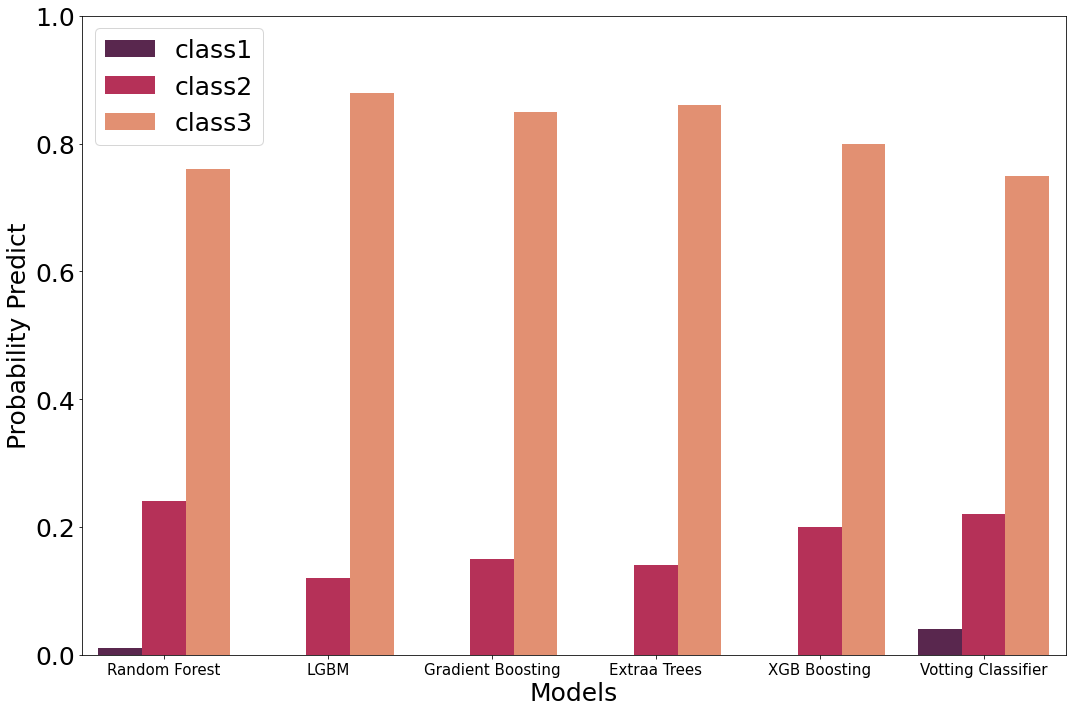

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))

sns.color_palette("rocket", as_cmap=True)

sns.barplot(data=df_models, x='models', y='percent', hue='classe', palette='rocket')

plt.ylim([0, 1])
plt.legend(prop={'size': 25})
plt.ylabel('Probability Predict', size=25)
plt.xlabel('Models', size=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.show()

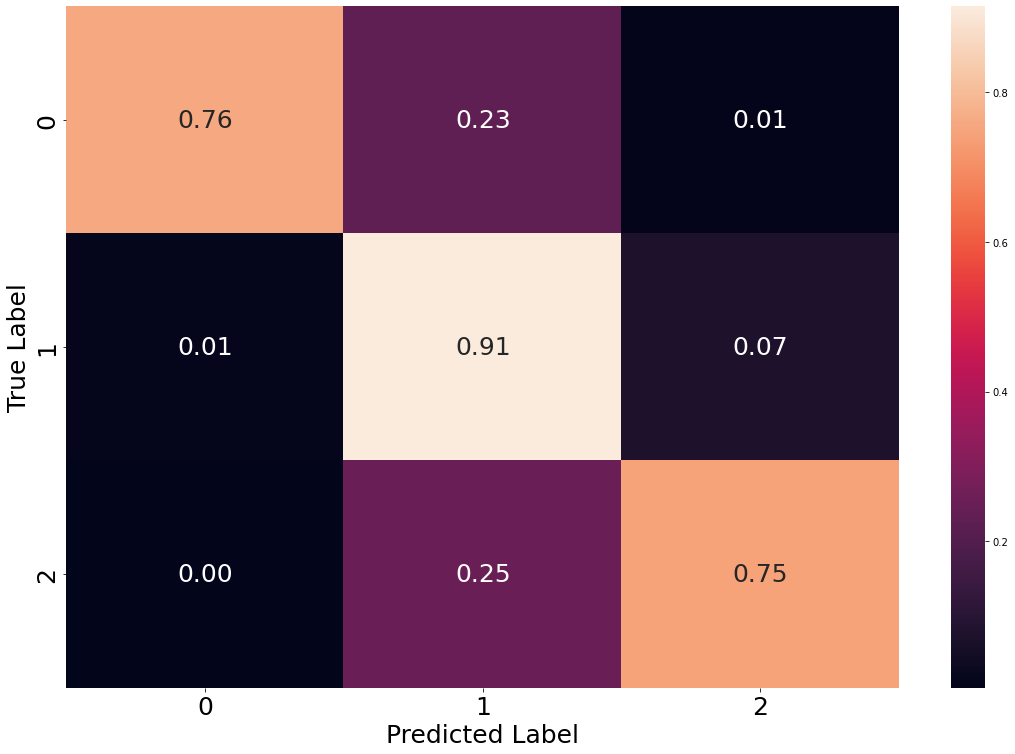

In [ ]:
cm = confusion_matrix(fy_tr, pred_votting, labels=voting_clf.classes_)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(cmn, annot=True, fmt='.2f', annot_kws={'size': 25}, ax=ax)
fig.tight_layout()
plt.ylabel('True Label', size=25)
plt.xlabel('Predicted Label', size=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show(block=False)

# Submit

In [ ]:
pred_votting_base_test = voting_clf.predict(fx_te)

sub_csv = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/data/submission_format.csv")

sub_csv["damage_grade"] = pred_votting_base_test
sub_csv.to_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/output/submit/generated_data_2.csv", index=False)

In [ ]:
sub_csv = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/data/submission_format.csv")

sub_csv["damage_grade"] = pred_votting_base_test
sub_csv.to_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/output/submit/ensemble_1.csv", index=False)

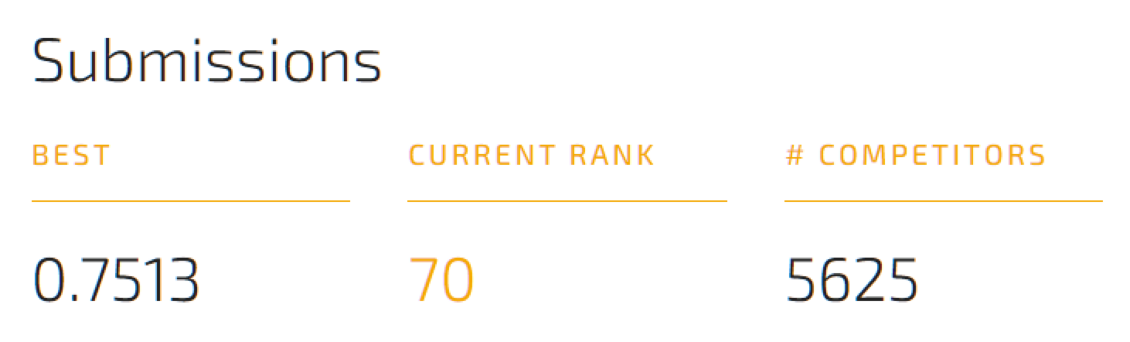

In [ ]:
img = cv2.imread("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/data/Results 2022-08-08.png")

plt.figure(figsize=(20, 16))
plt.imshow(img)
plt.axis('off')
plt.show()